# Initialization and Optimization

```{admonition} Attribution
This notebook is based on [Tutorial 3: Initialization and Optimization](https://pytorch-lightning.readthedocs.io/en/latest/notebooks/course_UvA-DL/03-initialization-and-optimization.html) of the [Pytorch Lightining official tutorials](https://pytorch-lightning.readthedocs.io/en/latest/index.html) with all PyTorch code translated to TensorFlow. Also some changes in the discussion and code logic.
```

In this notebook, we will review techniques for optimization and initialization of neural networks. When increasing the depth of neural networks, there are various challenges we face. Most importantly, we need to have a stable gradient flow through the network, as otherwise, we might encounter vanishing or exploding gradients. This is why we will take a closer look at the following concepts: initialization and optimization.

In the first half of the notebook, we will review different initialization techniques, and go step by step from the simplest initialization to methods that are nowadays used in very deep networks. In the second half, we focus on optimization comparing the optimizers SGD, SGD with Momentum, and Adam.

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)
tf.config.list_physical_devices()

2.7.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
import pathlib
import json
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Path to datasets
DATASET_PATH = pathlib.Path(os.getcwd()).parents[2] / "data"
DATASET_PATH.mkdir(exist_ok=True, parents=True)

## Preparation

Throughout this notebook, we will use a deep fully connected network, similar to our previous tutorial. We will also again apply the network to FashionMNIST, so you can relate to the results in the previous notebook. We start by loading the FashionMNIST dataset:


In [14]:
# Transformations applied on each image. 
def transform_image(image):
    return tf.reshape(tf.image.per_image_standardization(image), (-1,))


FMNIST, FMNIST_info = tfds.load(
    'fashion_mnist', 
    data_dir=DATASET_PATH, 
    with_info=True, 
    shuffle_files=False
)

train_ds, test_ds = FMNIST['train'], FMNIST['test']
train_ds = train_ds.map(lambda x: (transform_image(x['image']), x['label']))
test_ds = test_ds.map(lambda x: (transform_image(x['image']), x['label']))

Let's look at the distribution of pixel values in a batch of images (after standardization):

2022-02-08 23:26:44.819904: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


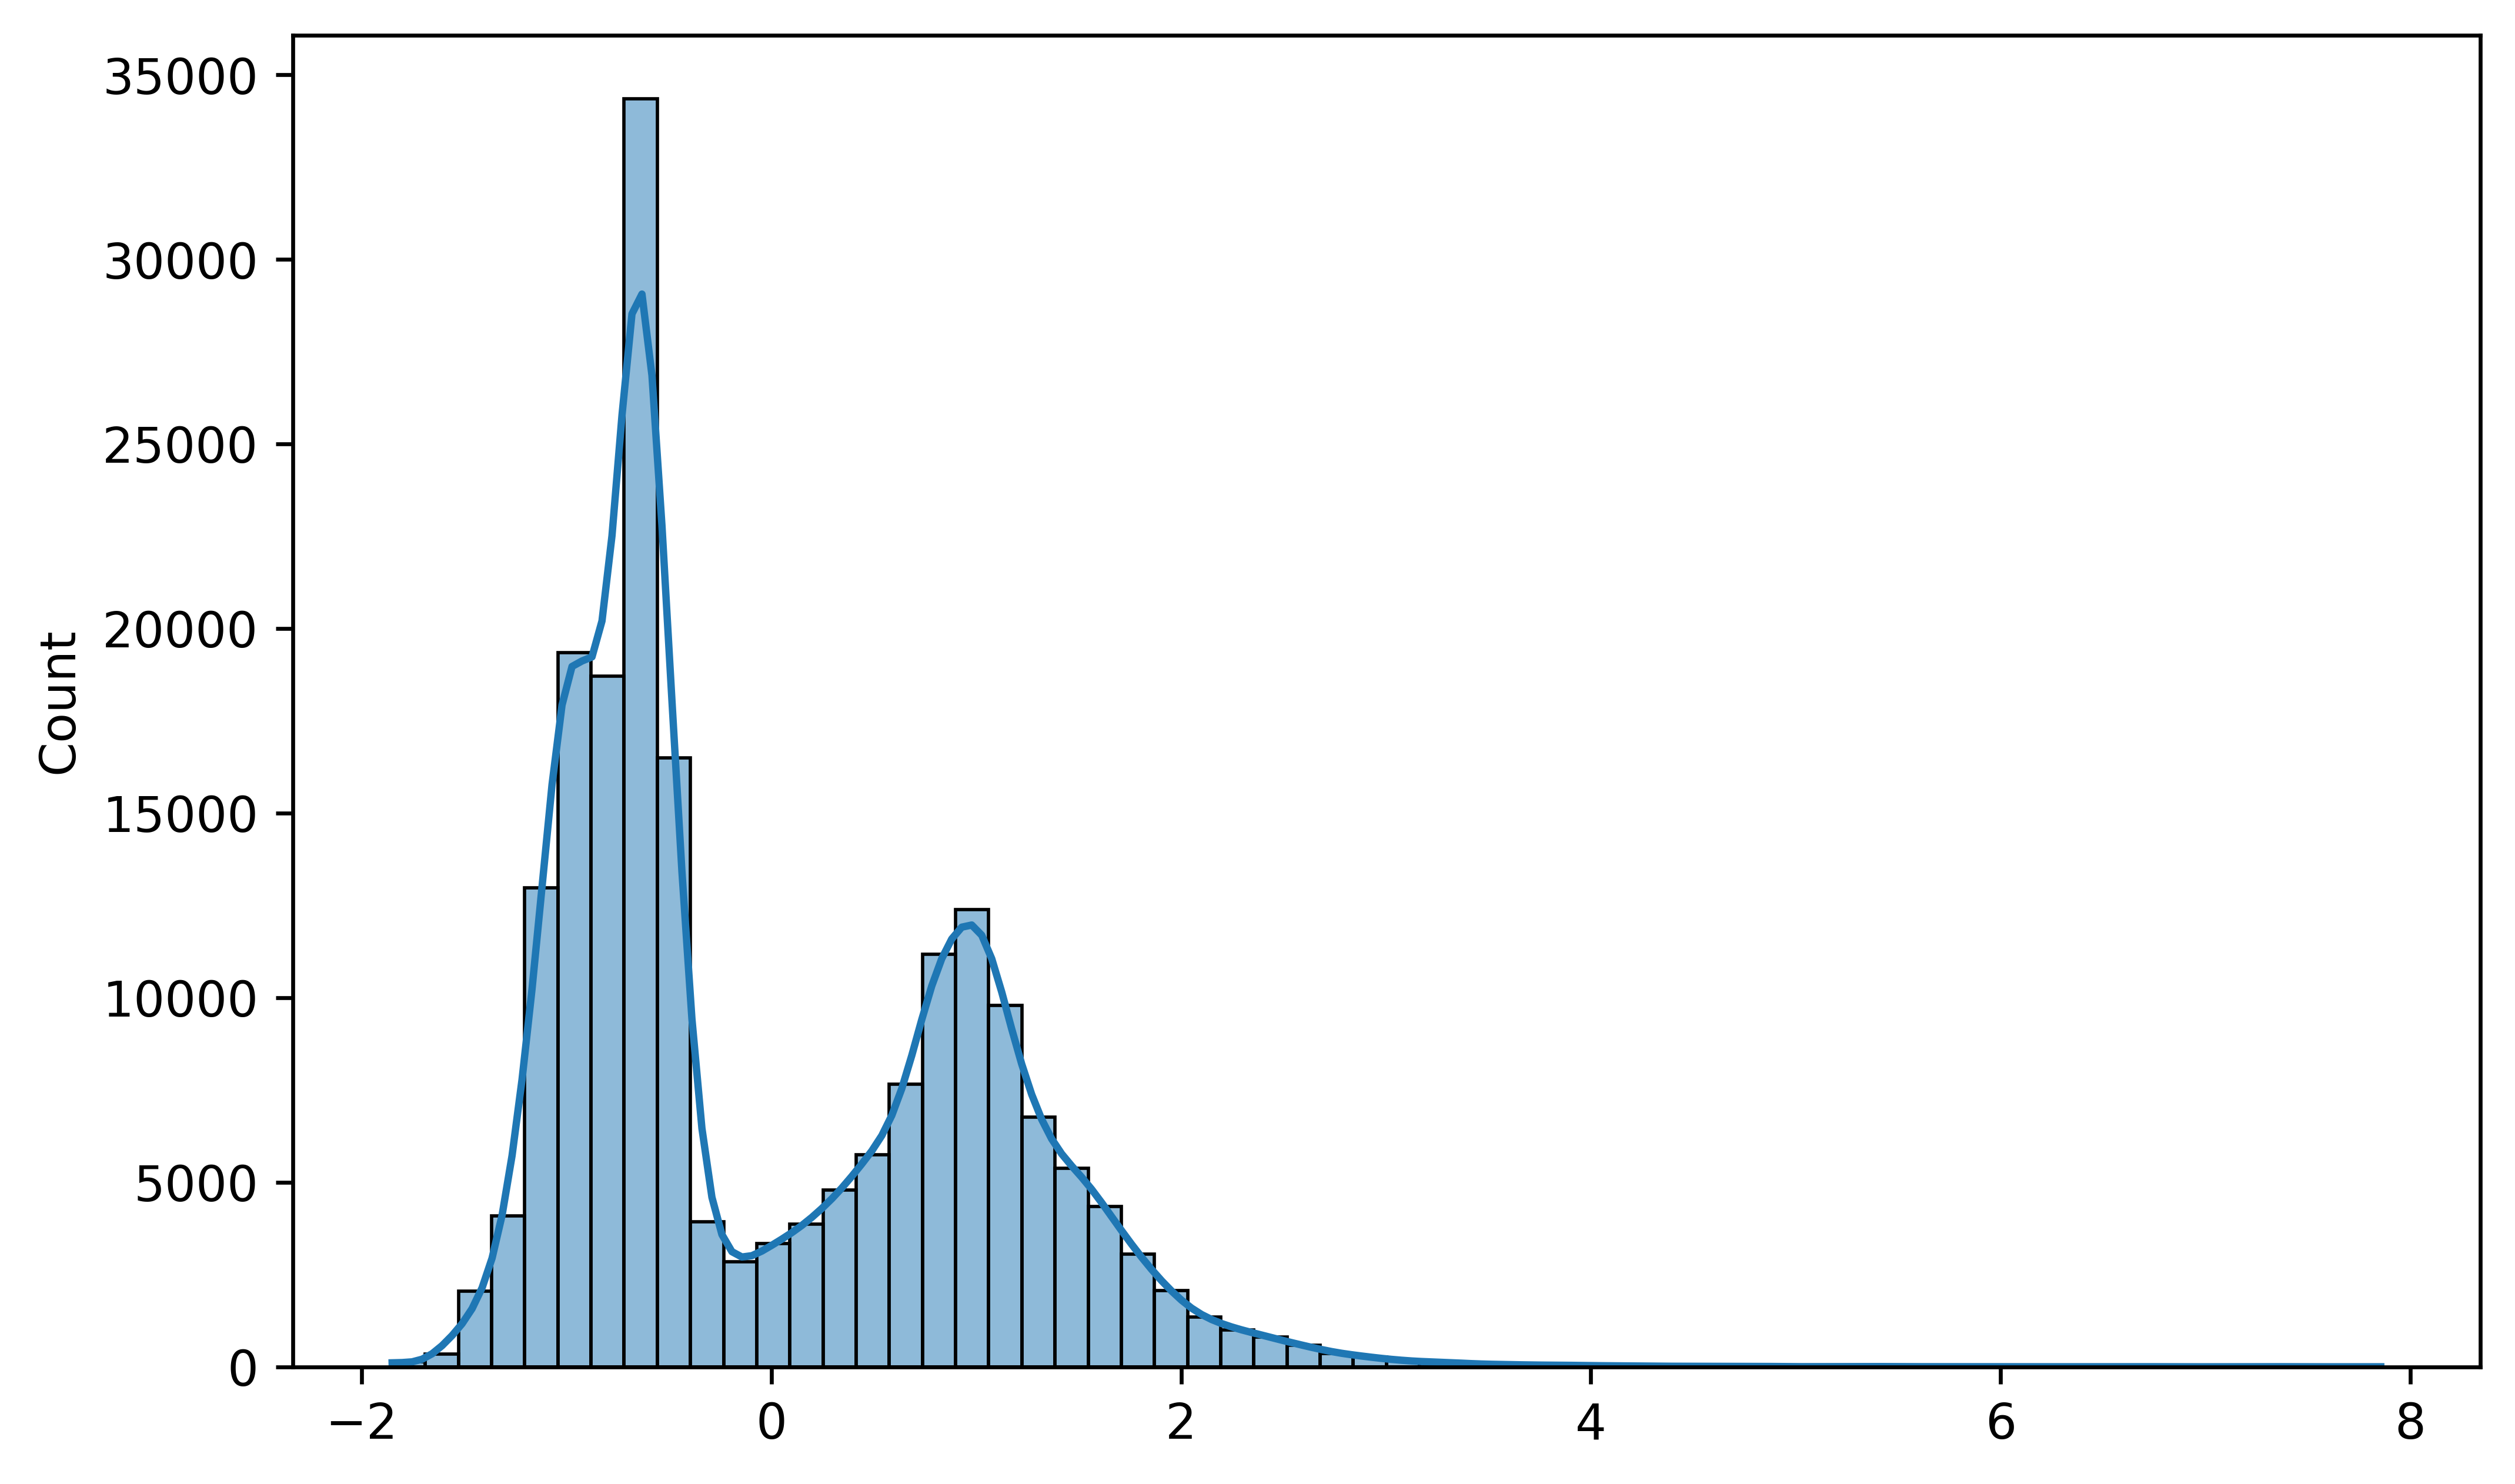

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=600)
batch = next(iter(train_ds.batch(256)))[0].numpy()
sns.histplot(batch.reshape(-1), bins=60, kde=True);

Note that the maximum and minimum are not 1 and -1 anymore, but shifted towards the positive values. This is because FashionMNIST contains a lot of black pixels, similar to MNIST.

In comparison to the previous tutorial, we rescaled each image from `[0, 255]` to `[0, 1]`. The normalization is now designed to give us an expected mean of `0` and a standard deviation of `1` across pixels for each image. This will be particularly relevant for the discussion about initialization we will look at below, and hence we change it here. It should be noted that in most classification tasks, both normalization techniques (between -1 and 1 or mean 0 and standard deviation 1) have shown to work well. We can calculate the normalization parameters by determining the mean and standard deviation on the original images:

In [92]:
images, _ = next(iter(train_ds.batch(256)))
images = images.numpy()

# Per image stats of pixel values, averaged over batch
print(images.mean(axis=1).mean(), images.std(axis=1).mean())
print(images.max(axis=1).mean(), images.min(axis=1).mean())

2.7797142e-10 1.0
2.586051 -0.8733395


2022-02-09 11:21:08.005611: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Next, we create a linear neural network. We use the same setup as in the previous tutorial.


In [93]:
def base_net(act_fn, num_classes=10, hidden_sizes=(512, 256, 256, 128)):
    """Return an initialized MLP network with dense hidden layers with activation
    `act_fn` and width in `hidden_sizes` ordered such that index zero is nearest 
    the input layer, and a final linear layer (logits) of width `num_classes`."""

    model = tf.keras.Sequential()

    # Add hidden layers with activation
    for j in range(len(hidden_sizes)):
        model.add(tf.keras.layers.Dense(
            units=hidden_sizes[j], 
            kernel_initializer=tf.keras.initializers.HeNormal(seed=RANDOM_SEED)
        ))
        model.add(act_fn())

    # Add logit linear layer
    model.add(tf.keras.layers.Dense(units=num_classes))
    return model

For the activation functions, we make use of Keras' `tf.keras.activations` library instead of implementing ourselves. However, we also define an `Identity` activation function. Although this activation function would significantly limit the network’s modeling capabilities, we will use it in the first steps of our discussion about initialization (for simplicity).



In [94]:
class Identity(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return x
        
        
class Tanh(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return tf.keras.activations.tanh(x)
        

act_fn_by_name = {
    "tanh": Tanh,
    "relu": tf.keras.layers.ReLU,
    "identity": Identity
}

Finally, we define a few plotting functions that we will use for our discussions. These functions help us to (1) visualize the weight/parameter distribution inside a network, (2) visualize the gradients that the parameters at different layers receive, and (3) the activations, i.e. the output of the linear layers. The detailed code is not important, but feel free to take a closer look if interested.